# Building a clickbait classification pipeline

![Clickbait](http://www.ogilvy.com/wp-content/uploads/2015/10/166_main.jpg)

## Introduction

The aim of this workshop is to walk you through the process of taking data to a production machine learning classifier for text. You'll build a classifier to detect clickbait from the article text and eventually roll out the classifier into an app.

We'll be using
 - pandas for data wrangling
 - matplotlib for plotting
 - scikit-learn for feature engineering, model building, and model analysis
 - flask for building our web app
 - jupyter for getting stuff done

By the end of the workshop you'll understand the steps needed to build a basic text processing pipeline.

## Loading data and wrangling

You've been presented with tabular data in a `.csv` format. A natural choice for loading the data is pandas, which is based around tabular representations.

We'll load in the data and get a broad overview of the data.

In [25]:
import pandas as pd
%matplotlib inline

In [26]:
df = pd.read_csv(r'E:\PythonProjects\Python\src\bin\Machine_Learning\data\training_data.csv')
df.head(5)

,author,description,label,publishedAt,title
0,Julia Reinstein,"Trust no man, trust no brand. (This post will ...",1,NaN,The Definitive Guide To The Best April Fools’ ...
1,Natalya Lobanova,Not that anyone should need convincing of thei...,1,NaN,Literally Just 19 Pictures That Prove Hedgehog...
2,"Kat Angus, Jane Lytvynenko","You can only have one, eh?",1,NaN,"""Would You Rather"": Canadian Food Vs. Canadian..."
3,Ben Coleman,"""It's gonna rip my eyebrow off!""",1,NaN,"Guys Try The ""Most Painful"" Face Mask"
4,Ellie Bate,"No, your hair colour won't make a difference.",1,NaN,"Which ""Riverdale"" Family Do You Belong In?"


### Article details

An article contains:
 - **author** (string) - the article author's name
 - **description** (string) - a short description of the article
 - **label** (interger) - 1=clickbait 0=not clickbait
 - **publishedAt** (string) - a timestamp for the time of publication
 - **title** (string) - the title of the article

We can print the content of one article:

In [27]:
print(df['title'][1])
print('-----')
print(df['description'][1])
print('Published at:', df['publishedAt'][1])

Literally Just 19 Pictures That Prove Hedgehogs Are Ridiculously Cute
-----
Not that anyone should need convincing of their cuteness, tbh.
Published at: nan


### Basic statistics

Pandas makes it easy to inspect, plot, and transform our data. Pandas is easy to use but still has lots of functionality. When you can chain multiple functions together, you've become a pandas pro!

In [28]:
# Number of clickbait and non-clickbait articles
df['label'].value_counts()

0    808
1    557
Name: label, dtype: int64

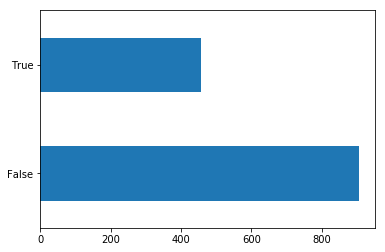

In [29]:
# Plotting the number of author fields that are Null
df['author'].isnull().value_counts().plot('barh')

In [30]:
# The number of characters in the description field
df['description'].apply(len).mean()

85.323076923076925

In [31]:
# Comparing the number of description characters in clickbait to news
df['description'].apply(len).groupby(df['label']).mean()

label
0    111.623762
1     47.170557
Name: description, dtype: float64

In [32]:
# TEST YOUR KNOWLEDGE
# Can you write a one-liner to compute the number of clickbait articles
# written by each author? Hint: you might find the .sum() function helpful!

### Create the full content column

In [33]:
df['full_content'] = df.description + ' ' + df.title
df.head(1)

,author,description,label,publishedAt,title,full_content
0,Julia Reinstein,"Trust no man, trust no brand. (This post will ...",1,NaN,The Definitive Guide To The Best April Fools’ ...,"Trust no man, trust no brand. (This post will ..."


Nice work - have a panda

![panda](http://www.nathab.com/uploaded-files/carousels/TRIPS/Wild-China/Asia-Wild-China-4-panda.JPG)

---

# Scikit-learn text classification pipeline


Some important terminology:

<img src="http://tfwiki.net/mediawiki/images2/thumb/3/37/Optimusg1.jpg/350px-Optimusg1.jpg" alt="optimus" style="width:50px;" align="left"/> **TRANSFORMERS** - take some input data and transform it into another format. Often we want to transform textual data or image data into numerical data. We may also transform our input data into new features
<br/>
<br/>

<img src="http://www.kennyskiphire.co.uk/blog/wp-content/uploads/Wheelie-Bins.jpg" alt="bins" style="width:70px;" align="left"/> **CLASSIFIERS** - take some input data and classify the sample by assigning a label to the input data. In binary classification we often use the labels 1 and 0.
<br/>
<br/>

<img src="https://reichanjapan.files.wordpress.com/2016/02/mariogiftcard.png?w=230&h=335" alt="pipe" style="width:50px;" align="left"/> **PIPELINE** - consist of one or many transformer steps followed by a classifier. We can use pipelines to elegantly chain together operations and construct an easy to use interface. 

## Textual to numerical data (bag of words model) 

Our classifier isn't going to understand text like we can - we must create numerical data. A common approach to this is the bag of words model. 

For example - **Literally just 8 really really cute dogs** - transforms into the bag of words:

| Token | id | Count |
|---|---|---|
| cute | 0 |1 |
| dogs | 1 |1 |
| just | 2 | 1 |
| literally | 3 | 1 |
| really | 4 | 2 |

This is simply achieved with a scikit-learn `CountVectorizer`. There are two steps:
 - **Fit** the vectorizer, which populates all the tokens in the left hand column and assigns the numerical ids
 - **Transform** the data, which turns a sentence into it's bag of words representation
 
 Note that the bag of words representation of a sentence ignores the word order and dependencies between them.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

Fitting the `CountVectorizer` learns the vocabulary

In [35]:
sentence = ["Literally just 8 really really cute dogs"]
vectorizer.fit(sentence)
print(vectorizer.vocabulary_) # dictionary of words and ids

{'literally': 3, 'just': 2, 'really': 4, 'cute': 0, 'dogs': 1}


We can then transform our textual to numerical data

In [36]:
vectorizer.transform(sentence).toarray()

array([[1, 1, 1, 1, 2]], dtype=int64)

Note: we cannot transform textual data that is not in our learned vocabulary.

In [37]:
sentence = ["OMG 5 truly hilarious dogs 😂"]
vectorizer.transform(sentence).toarray()

array([[0, 1, 0, 0, 0]], dtype=int64)

## Classifier

In the classification task, we take a single example (such as an article row) and decide which class it belongs to (e.g., clickbait or not clickbait). A standard approach to classification is to find a boundary that best seperates training examples according to their class. In the binary classification problem below, we've indicated a linear boundary that separates the data pretty well. Each sample is described by the number of times that word1 and word2 occur. In reality we will have many more words associated with each sample but the concept remains the same.

We determine this boundary using a Support Vector Machine. The SVM has two steps:
 - **Fit** we learn the boundary from labelled data
 - **Predict** we predict the classes of unlabelled data

![classify](images/svm-classify.png)

In [38]:
from sklearn.svm import LinearSVC
svc = LinearSVC()

Let's make up some samples.

In [39]:
bag_of_words = [
    [1, 5], [1, 4], [2, 6], [4, 2], [3, 4], [2, 1]
]
labels = [1, 1, 1, 0, 0, 0]

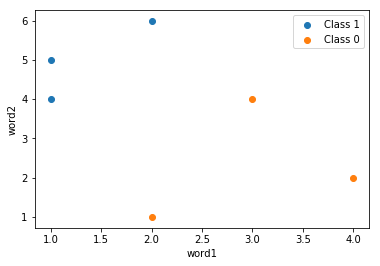

In [40]:
from utils.plotting import plot_2d_samples
plot_2d_samples(bag_of_words, labels)

Now we learn the boundary!

In [41]:
svc = svc.fit(bag_of_words, labels)

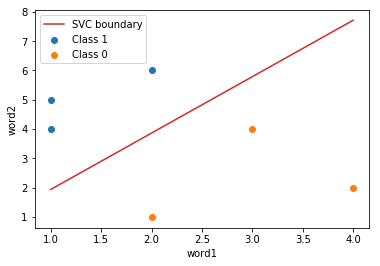

In [42]:
from utils.plotting import plot_2d_trained_svc
plot_2d_trained_svc(bag_of_words, labels, svc)

Once we have learned the boundary then we can predict the label of novel samples

In [43]:
svc.predict([[3, 1], [2,4]])

array([0, 1])

## Putting it all together in a pipeline

A pipeline consists of multiple transform steps and a final classification step. A pipeline is an easy way to wrap up all our transformations in one easy to use box. In general we use the following functions:
 - **Fit** to fit the transformers and classifier
 - **Predict** to transform data and predict it's label
 
Below is a detailed schematic of the data flow in the pipeline when we call these two methods.

![pipeobj](images/sklearn-pipeline.png)

We'll create a pipeline with two steps:
1. Transform textual data to a bag of words vector
2. Predict label from the bag of words vector

So the input of our pipeline is text data and the output is a label!

In [44]:
steps = (
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC())
)

In [45]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps)

**Congratulations!** You've built your first text classification pipeline.
![pipeygif](https://tinynin.files.wordpress.com/2012/01/warppipe-copy.gif)

## Training our pipeline on real data

Now that we know how the vectorizer and classifier work together to form a pipeline, we can train it on the real data. 

**Machine learning discipline 101**
 - Split your data into a training and testing set
 - NEVER look at your testing data. Hide it away. Save it for later. Lock it in a drawer!
 - Your training data helps you to fit your models and select one
 - Your testing data is used for final evaluation
 
Scikit-learn's train and test split shuffles our data and splits it into two sets. We can also use *stratified sampling* to ensure that both sets have the same distribution of labels.

In [46]:
from sklearn.model_selection import train_test_split
training, testing = train_test_split(
    df,                # The dataset we want to split
    train_size=0.7,    # The proportional size of our training set
    stratify=df.label, # The labels are used for stratification
    random_state=400   # Use the same random state for reproducibility
)

In [47]:
training.head(5)

,author,description,label,publishedAt,title,full_content
941,NaN,The 2016 rains failed in the Horn of Africa; t...,0,2017-04-16T10:29:00Z,Will the 'Long Rains' save Somalia?,The 2016 rains failed in the Horn of Africa; t...
906,Steve Chao,Are pandas destined to survive only in captivity?,0,2017-04-15T07:06:36Z,Saving China's pandas,Are pandas destined to survive only in captivi...
1275,NaN,"The landslide overturned vehicles, buried buil...",0,2017-04-02T09:29:15Z,Indonesia landslide search halted amid heavy r...,"The landslide overturned vehicles, buried buil..."
193,Susana Cristalli,It doesn't mean there's something wrong with y...,1,NaN,12 Gripes From People Who Have No Problem Doin...,It doesn't mean there's something wrong with y...
1195,Ylenia Gostoli,The arrest of Birzeit University student Kifah...,0,2017-04-25T09:45:09Z,How Israel denies rights to Palestinian prisoners,The arrest of Birzeit University student Kifah...


In [48]:
print(len(training))
print(len(testing))

955
410


### Train

Now we're ready to train!

In [49]:
pipeline = pipeline.fit(training.title, training.label)

What? That was it?! 

That's right. You've just built a machine learning classifier for clickbait and it was that easy to train. Let's test it out:

In [50]:
pipeline.predict(["10 things you need to do..."])

array([1], dtype=int64)

In [51]:
pipeline.predict(["French election polls show an early lead for Macron."])

array([0], dtype=int64)

## Introspect our model

In [52]:
from utils.plotting import print_top_features
print_top_features(pipeline, n_features=10)

Top clickbait features:
['get' 'these' '21' 'alcohol' 'things' 'that' 'times' 'this' 'your' 'you']
---
Top news features:
['jerusalem' 'french' 'media' 'presidential' 'still' 'elections' 'vote'
 'somalia' 'attack' 'trump']


## Evaluating our model

Cross-validation is a method of measuring model performance:
1. Split the training data into $n$ chunks
2. Train the pipeline on all but one of the chunks
3. Predict the label of the samples in the remaining chunk
4. Repeat this until we have predicted the labels of the entire training set

In [53]:
from sklearn.model_selection import cross_val_predict
predicted_labels = cross_val_predict(pipeline, training.title, training.label)

Now we have our predicted labels, we can check our performance

Accuracy = 91.8%
Confusion matrix, without normalization
[[552  13]
 [ 65 325]]


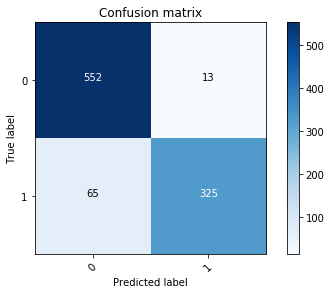

In [54]:
from utils.plotting import pipeline_performance
pipeline_performance(training.label, predicted_labels)

It's always a good idea to inspect those samples that we got wrong.

In [55]:
training[training.label != predicted_labels]

,author,description,label,publishedAt,title,full_content
268,Matt Stopera,This is challenging.,1,NaN,Random-Ass White Dude Or A Guy From The Chains...,This is challenging. Random-Ass White Dude Or ...
46,Keely Flaherty,"Let's do this, nerds.",1,NaN,Only A True Pop Culture Nerd Will Recognize 75...,"Let's do this, nerds. Only A True Pop Culture ..."
385,Alyson Martin,More than half the states in the country have ...,1,2017-04-04T14:58:33+00:00,A 19-Year-Old Nearly Died After A Hospital Sai...,More than half the states in the country have ...
149,Tanya Chen,The mom assures us that James is OK. And as sh...,1,NaN,A Mom Walked Into A Hilarious Scene After Her ...,The mom assures us that James is OK. And as sh...
1330,NaN,He was caught on camera.,0,2017-04-02T10:37:08Z,Naked man who helped elderly couple with wheel...,He was caught on camera. Naked man who helped ...
940,NaN,Candidates must convince voters they are best ...,0,2017-04-17T12:19:58Z,French presidential elections: What you need t...,Candidates must convince voters they are best ...
1351,NaN,An upcoming film exposes the gender gap in yet...,0,2017-04-02T14:14:19Z,This documentary inspires pilots to 'fly like ...,An upcoming film exposes the gender gap in yet...
849,Ketan Alder,Hindu nationalists have reshaped Indian politi...,0,2017-04-13T10:58:00Z,How the BJP has come to dominate lower-caste p...,Hindu nationalists have reshaped Indian politi...
294,"Ahmed Ali Akbar, See Something Say Something","Some people call them ""loanwords,"" but that im...",1,NaN,Which One Of These Words Was Stolen During Col...,"Some people call them ""loanwords,"" but that im..."
1237,NaN,They have been married for nearly 60 years whe...,1,2017-04-02T07:57:59Z,Christopher Timothy and Maggie Steed on EastEn...,They have been married for nearly 60 years whe...


## Improving the model

We had pretty high accuracy but can we do better?

### Use title and descritption

Rather than using just the title, we could use the title and description together.

Accuracy = 93.4%
Confusion matrix, without normalization
[[535  30]
 [ 33 357]]


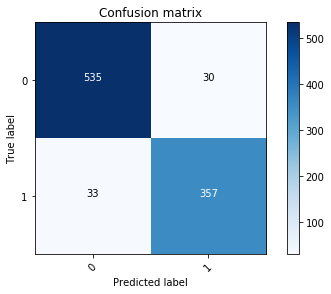

In [56]:
predicted_labels = cross_val_predict(pipeline, training.full_content, training.label)
pipeline_performance(training.label, predicted_labels)

### TfidfVectorizer Transformer

The TfidifVectorizer is an improved version of the CountVectorizer. Words are still transformed into a bag of words but we emphasise the importance of less common words.

Accuracy = 94.5%
Confusion matrix, without normalization
[[554  11]
 [ 42 348]]


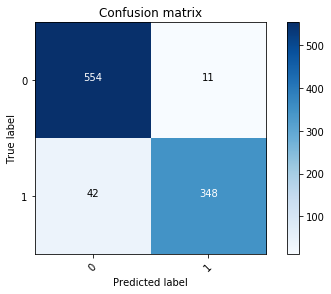

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

steps = (
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC())
)
pipeline = Pipeline(steps)

predicted_labels = cross_val_predict(pipeline, training.full_content, training.label)
pipeline_performance(training.label, predicted_labels)

### Replace ordinals

Earlier we saw that numbers are very common in clickbait articles, they are likely to be a very descriptive feature. However our vocabulary is limited by the numbers that we saw in training. We could replace all numbers by some label so that all numbers are represented equally.

All we need to do is write a string preprocessor and pass it to the vectorizer.

Accuracy = 96.5%
Confusion matrix, without normalization
[[563   2]
 [ 31 359]]


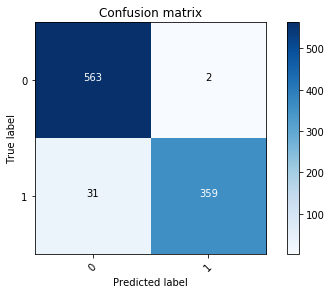

In [58]:
import re
def mask_integers(s):
    return re.sub(r'\d+', 'INTMASK', s)

steps = (
    ('vectorizer', TfidfVectorizer(preprocessor=mask_integers)),
    ('classifier', LinearSVC())
)
pipeline = Pipeline(steps)

predicted_labels = cross_val_predict(pipeline, training.full_content, training.label)
pipeline_performance(training.label, predicted_labels)

### Hyperparameters

When we constructed our `LinearSVC` and `CountVectorizer` we used the default model parameters. These additonal parameters (hyperparameters) can be chosen to improve our classifier by performing a grid search. A grid search trains a classifier on every combination of the parameters and analyses their performance. We can then pick the best one.

In [59]:
steps = (
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LinearSVC())
)

pipeline = Pipeline(steps)

Some parameters we can fiddle:
 - stop_words - we can ignore certain words (the, a, it,...). scikit-learn has an 'english' stop word vocabulary we can use
 - ngram_range - in the above example we split sentences into words. We could also try pairs of words.
 - C - the SVM has a property C that performs regularisation
 
We set up our grid as a dictionary (note we must use the step names so that scikit learn knows which component we are fiddling with):

In [60]:
gs_params = {
    'vectorizer__stop_words': ['english', None],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'vectorizer__preprocessor': [mask_integers, None],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(pipeline, gs_params, n_jobs=-1)
gs.fit(training.full_content, training.label)

In [ ]:
print(gs.best_params_)
print(gs.best_score_)

## Testing generality

So far we have selected our model based on the training data alone. It looks like our performance is excellent but we may have overfit to the training data. Does our classifier generalise well?

In other words, do we perform as well on data that we have never seen before?

In [ ]:
pipeline = gs.best_estimator_
predicted_labels = pipeline.predict(testing.full_content)
pipeline_performance(testing.label, predicted_labels)

HURRAH!

# Going into the wild

![hunger](https://ronanwills.files.wordpress.com/2015/06/vlcsnap-2015-06-11-23h05m49s76.png?w=625)

An excellent feature of scikit-learn is that we can save our classifier using the pickle tool. We can load it later for
 - data analysis
 - data provenance
 - to share with somebody
 - to provide ML as a service (coming up)

In [ ]:
filename = 'classifiers/clickbait_svc_v1'

In [ ]:
import pickle
with open(filename, 'wb') as f:
    pickle.dump(pipeline, f)

# Congratulations

You've built a clickbait classifer. Head over to `advanced.ipynb` or look through the `webservice` directory to put your pipeline to use.

![gatsby](https://media.tenor.co/images/78f5d1acd72e8a66257ea671b4aefd5f/tenor.gif)
